In [1]:
using Distributions
using Rocket
using ReactiveMP
using BenchmarkTools
using Plots

import ProgressMeter
using Random

import Base: show
import PDMats: PDMat

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.


In [2]:
function hgf(n, iters, data, z_covariance, y_covariance, kfunction)
    model = Model(DefaultMessageGate())
    
    xt_min_mean = add!(model, datavar(:xt_min_mean, Dirac{Vector{Float64}}))
    xt_min_cov  = add!(model, datavar(:xt_min_cov, Dirac{PDMat{Float64, Matrix{Float64}}}))
    xt_min      = add!(model, randomvar(:xt_min))
    
    xt_min_prior = add!(model, make_node(MvNormalMeanCovariance, xt_min, xt_min_mean, xt_min_cov))
    
    zt_min_mean = add!(model, datavar(:zt_min_mean, Dirac{Vector{Float64}}))
    zt_min_cov  = add!(model, datavar(:zt_min_cov, Dirac{PDMat{Float64, Matrix{Float64}}}))
    zt_min      = add!(model, randomvar(:zt_min))
    
    zt_min_prior = add!(model, make_node(MvNormalMeanCovariance, zt_min, zt_min_mean, zt_min_cov))
    
    zcov   = add!(model, constvar(:zcov, z_covariance))
    zt     = add!(model, randomvar(:zt))
    
    z_transition = add!(model, make_node(MvNormalMeanCovariance, zt, zt_min, zcov, factorisation = ((1,2),(3,))))
    
    xt = add!(model, randomvar(:xt))
    
    gcv = add!(model, make_node(KernelGCV, KernelGCVMetadata(kfunction, ghcubature(2)), xt, xt_min, zt))
    
    ycov = add!(model, constvar(:ycov, y_covariance))
    y    = add!(model, datavar(:y, Dirac{Vector{Float64}}))
    
    obs = add!(model, make_node(MvNormalMeanCovariance, y, xt, ycov))
    
    activate!(model)
    
    ms_scheduler = PendingScheduler()
    fe_scheduler = PendingScheduler() # 
    fe = Vector{Float64}()    
    # fe_sub = subscribe!(score(BetheFreeEnergy(), model, fe_scheduler), (d) -> push!(fe, d))
    
    mz = Vector{MvNormalMeanCovariance}()
    mx = Vector{MvNormalMeanCovariance}()

    s_mz = subscribe!(getmarginal(zt) |> schedule_on(ms_scheduler), (t) -> push!(mz, getdata(t)))
    s_mx = subscribe!(getmarginal(xt) |> schedule_on(ms_scheduler), (t) -> push!(mx, getdata(t)))
    
    # Initial prior messages
    current_zt = MvNormalMeanCovariance([ 0.0, 0.0 ], PDMat(Matrix(Diagonal([ 100.0, 100.0 ]))))
    current_xt = MvNormalMeanCovariance([ 0.0, 0.0 ], PDMat(Matrix(Diagonal([ 100.0, 100.0 ]))))

    # Prior marginals
    setmarginal!(gcv, :y_x, MvNormalMeanCovariance([ 0.0, 0.0, 0.0, 0.0 ], PDMat(Matrix(Diagonal([ 5.0, 5.0, 5.0, 5.0 ])))))
    setmarginal!(gcv, :z, MvNormalMeanCovariance([ 0.0, 0.0 ], PDMat([ 5.0 0.0 ; 0.0 5.0 ])))
    
    ProgressMeter.@showprogress for i in 1:n
        
        for _ in 1:iters
            update!(xt_min_mean, mean(current_xt))
            update!(xt_min_cov, cov(current_xt))
            update!(y, data[i])
            update!(zt_min_mean, mean(current_zt))
            update!(zt_min_cov, cov(current_zt))
            
            release!(fe_scheduler)
        end
        
        release!(ms_scheduler)
        
        current_zt = mz[end]
        current_xt = mx[end]
    end
    
    unsubscribe!(s_mz)
    unsubscribe!(s_mx)
    # unsubscribe!(fe_sub)
    
    return mz, mx, fe
end

hgf (generic function with 1 method)

In [3]:
using KernelFunctions
# import ForneyLab: softmax

gkernel = TransformedKernel(Matern32Kernel(), FunctionTransform(x -> sin.(x)));

In [4]:
import LinearAlgebra: Diagonal

n = 2000
iters = 50

Random.seed!(2113)

real_k = [ 1.0, 1.0 ]
real_w = [ -2.0, -1.0 ]

real_k = [ 1.0, 1.0 ]
real_w = [ 0.0, 0.0 ]

kfunction = (d) -> kernelmatrix(gkernel, d) .+ Diagonal(exp.(real_k .* d .+ real_w))
# kfunction = (d) -> Diagonal(exp.(real_k .* d .+ real_w))

z_prev       = [ 0.0, 0.0 ]
z_covariance = PDMat([ 0.01 0.0; 0.0 0.01 ])

z = Vector{Vector{Float64}}(undef, n)
for i in 1:n
    z[i] = rand(MvNormal(z_prev, sqrt(Matrix(z_covariance))))
    z_prev = z[i]
end

# z = map(d -> 2.0 * sin(0.005 * d), 1:n)

v = map(d -> kfunction(d), z)

x_prev = [ 0.0, 0.0 ]

x = Vector{Vector{Float64}}(undef, n)

for i in 1:n
    x[i] = rand(MvNormal(x_prev, sqrt(v[i])))
    x_prev = x[i]
end

y = Vector{Vector{Float64}}(undef, n)
y_covariance = PDMat([ 1.0 0.0; 0.0 1.0 ])

for i in 1:n
    y[i] = rand(MvNormal(x[i], sqrt(Matrix(y_covariance))))
end

In [9]:
@time mz, mx, fe = hgf(n, iters, y, z_covariance, y_covariance, kfunction);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


 14.347789 seconds (100.34 M allocations: 8.086 GiB, 10.83% gc time)


In [6]:
function plot_dimension(mz, mx, dim = 1)
    z_layer = plot(map(d -> d[dim], mean.(mz)), ribbon = map(d -> sqrt(d[dim]), var.(mz)), label = :z)
    z_layer = plot!(z_layer, map(d -> d[dim], z), label = :real_z)

    x_layer = plot(map(d -> d[dim], mean.(mx)), ribbon = map(d -> sqrt(d[dim]), var.(mx)), label = :x)
    x_layer = plot!(x_layer, map(d -> d[dim], x), label = :real_x)

    plot(z_layer, x_layer, layout = (2, 1), size = (900, 600))
end

plot_dimension (generic function with 2 methods)

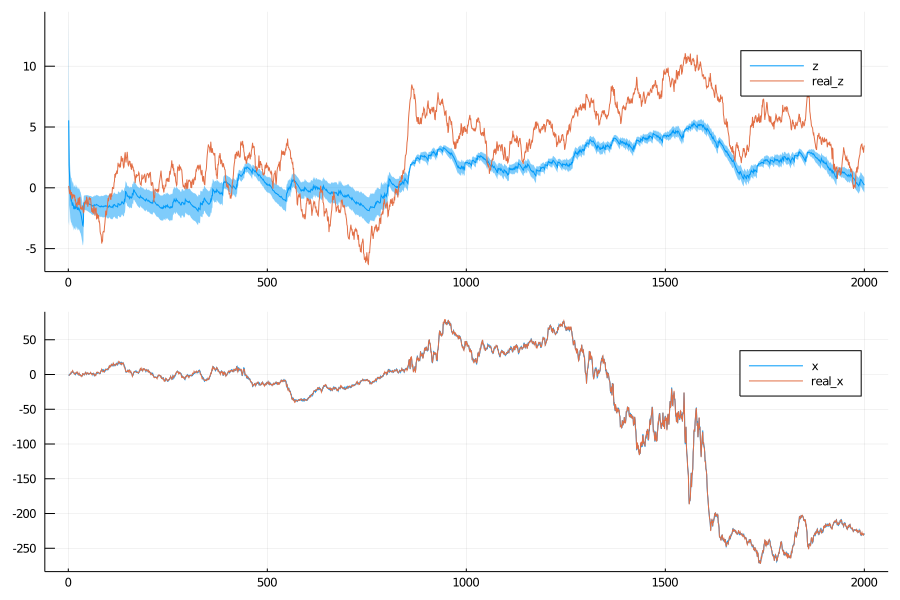

In [7]:
plot_dimension(mz, mx, 1)

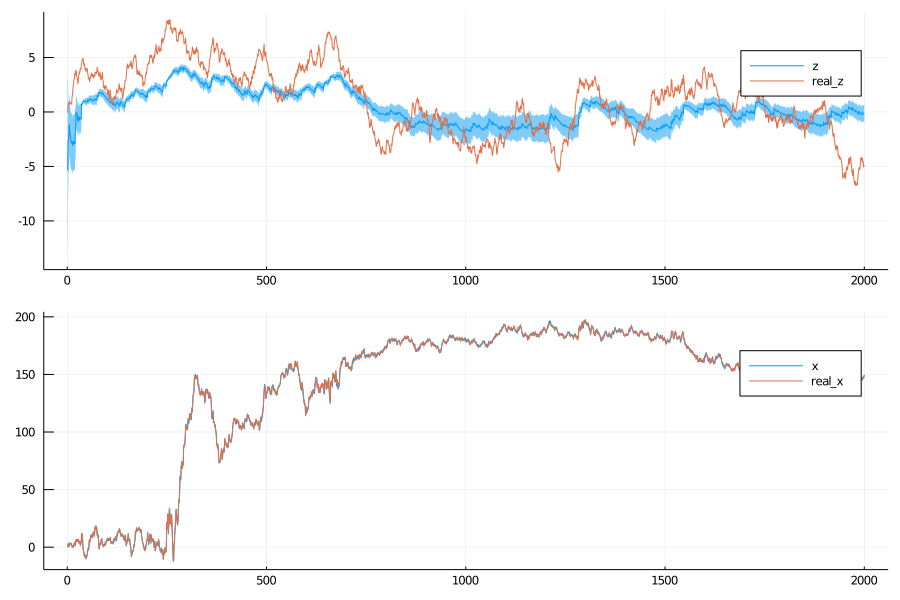

In [8]:
plot_dimension(mz, mx, 2)